In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [4]:
batch_size = 60
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


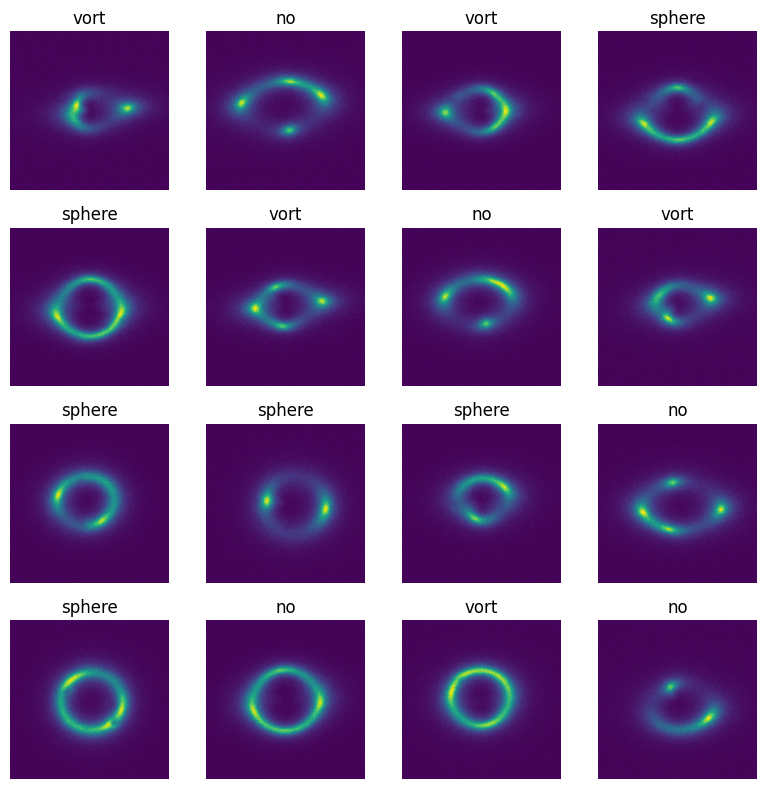

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [7]:
next(iter(train_loader))[0].shape

torch.Size([60, 1, 150, 150])

In [8]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, save_path='../best_param_CvT_1.pt'):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs).logits
            preds = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            train_corrects += torch.sum(idx == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).logits
                preds = F.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, idx = torch.max(preds, 1)
                val_corrects += torch.sum(idx == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

        model.load_state_dict(torch.load(save_path))

    return model

In [9]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            preds = F.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            total_corrects += torch.sum(idx == labels).item()

            y_pred_probs.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [10]:
from transformers import CvtForImageClassification, CvtConfig

config = CvtConfig()
config.num_labels = 3
config.image_size = 150
config.num_channels = 1
config.id2label = {'0': 'no', '1': 'sphere', '2': 'vort'}
config.label2id = {'no': 0, 'sphere': 1, 'vort': 2}
config.depth = [1, 2, 6]
config.embed_dim = [32, 96, 192]
model = CvtForImageClassification(config)
model.to(device)

configuration = model.config
print(configuration)
model

CvtConfig {
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    6
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    32,
    96,
    192
  ],
  "id2label": {
    "0": "no",
    "1": "sphere",
    "2": "vort"
  },
  "image_size": 150,
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "label2id": {
    "no": 0,
    "sphere": 1,
    "vort": 2
  },
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 1,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
   

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# Load checkpoint 1
model.load_state_dict(torch.load('../best_param_CvT_1.pt'))

In [19]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
criterion = nn.CrossEntropyLoss()

model = train_model(model, criterion, optimizer, scheduler, num_epochs=50, save_path='../best_param_CvT_1.pt')
print('Finished')

Epoch 1/50:
	Train Loss: 1.1095	Train Acc: 0.3350
	Val Loss: 1.1098	Val Acc: 0.3443
Epoch 2/50:
	Train Loss: 1.1032	Train Acc: 0.3306
	Val Loss: 1.0981	Val Acc: 0.3430
Epoch 3/50:
	Train Loss: 1.1016	Train Acc: 0.3357
	Val Loss: 1.1035	Val Acc: 0.3157
Epoch 4/50:
	Train Loss: 1.1020	Train Acc: 0.3321
	Val Loss: 1.1025	Val Acc: 0.3157
Epoch 5/50:
	Train Loss: 1.1026	Train Acc: 0.3308
	Val Loss: 1.1022	Val Acc: 0.3157
Epoch 6/50:
	Train Loss: 1.1020	Train Acc: 0.3301
	Val Loss: 1.0991	Val Acc: 0.3157
Epoch 7/50:
	Train Loss: 1.1016	Train Acc: 0.3338
	Val Loss: 1.1014	Val Acc: 0.3157
Epoch 8/50:
	Train Loss: 1.1010	Train Acc: 0.3360
	Val Loss: 1.1051	Val Acc: 0.3413
Epoch 9/50:
	Train Loss: 1.1000	Train Acc: 0.3356
	Val Loss: 1.1001	Val Acc: 0.3157
Epoch 10/50:
	Train Loss: 1.0998	Train Acc: 0.3344
	Val Loss: 1.0995	Val Acc: 0.3157
Epoch 11/50:
	Train Loss: 1.0997	Train Acc: 0.3343
	Val Loss: 1.0980	Val Acc: 0.3413
Epoch 12/50:
	Train Loss: 1.0995	Train Acc: 0.3384
	Val Loss: 1.1001	Val A

KeyboardInterrupt: 

In [ ]:
# Load checkpoint 1
model.load_state_dict(torch.load('../best_param_CvT_1.pt'))

Test Loss: 0.8855
Accuracy: 0.5655
ROC AUC: 0.7381


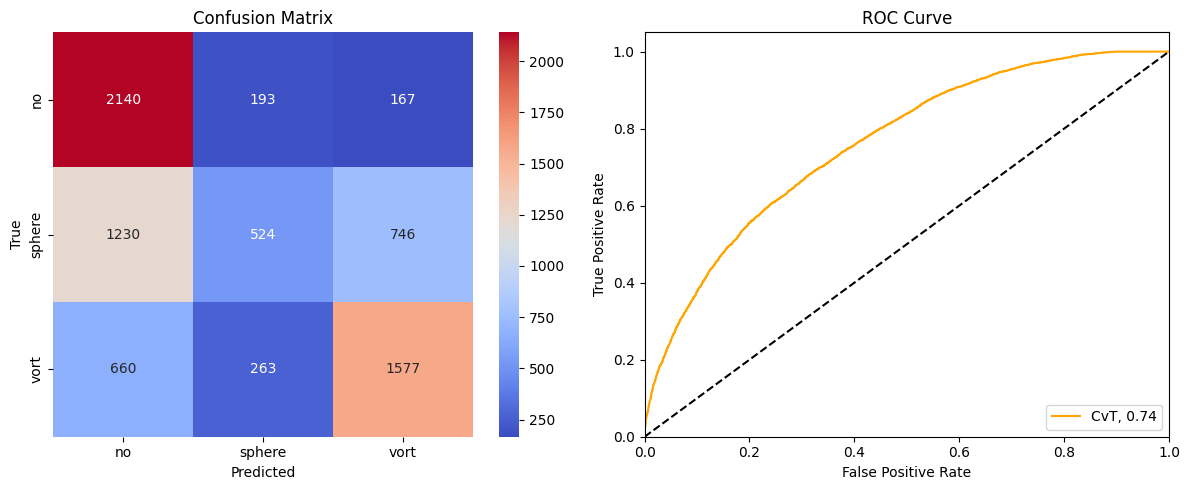

In [21]:
evaluate_model(model, criterion=nn.CrossEntropyLoss(), model_name='CvT')